##### Copyright 2022 The TensorFlow Authors.

In [1]:
#@title Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

# 使用 Core API 构建优化器

<table class="tfo-notebook-buttons" align="left">
  <td>     <a target="_blank" href="https://tensorflow.google.cn/guide/core/optimizers_core"><img src="https://tensorflow.google.cn/images/tf_logo_32px.png">在 TensorFlow.org 上查看</a> </td>
  <td>     <a target="_blank" href="https://colab.research.google.com/github/tensorflow/docs-l10n/blob/master/site/zh-cn/guide/core/optimizers_core.ipynb"><img src="https://tensorflow.google.cn/images/colab_logo_32px.png">在 Google Colab 中运行</a> </td>
  <td>     <a target="_blank" href="https://github.com/tensorflow/docs-l10n/blob/master/site/zh-cn/guide/core/optimizers_core.ipynb"><img src="https://tensorflow.google.cn/images/GitHub-Mark-32px.png">在 GitHub 上查看源代码</a> </td>
  <td>     <a href="https://storage.googleapis.com/tensorflow_docs/docs-l10n/site/zh-cn/guide/core/optimizers_core.ipynb"><img src="https://tensorflow.google.cn/images/download_logo_32px.png">下载笔记本</a> </td>
</table>

## 简介

本笔记本介绍使用 [TensorFlow Core 低级 API](https://tensorflow.google.cn/guide/core) 创建自定义优化器的过程。访问 [Core API 概述](https://tensorflow.google.cn/guide/core)以详细了解 TensorFlow Core 及其预期用例。

[Keras 优化器](https://tensorflow.google.cn/api_docs/python/tf/keras/optimizers)模块是一种推荐用于许多一般训练用途的优化工具包。它包含各种预构建的优化器，以及用于自定义的子类化功能。Keras 优化器还兼容使用 Core API 构建的自定义层、模型和训练循环。这些预构建和可自定义的优化器适用于大多数用例，但借助 Core API，您将可以完全控制优化过程。例如，锐度感知最小化 (SAM) 等技术需要模型与优化器耦合，这并不符合机器学习优化器的传统定义。本指南将逐步介绍使用 Core API 从头开始构建自定义优化器的过程，使您具备完全控制优化器的结构、实现和行为的能力。

## 优化器概述

优化器是一种用于针对模型可训练参数最小化损失函数的算法。最直接的优化技术为梯度下降，它会通过朝损失函数的最陡下降方向前进一步来迭代更新模型的参数。它的步长与梯度的大小成正比，当梯度过大或过小时都会出现问题。还有许多其他基于梯度的优化器，例如 Adam、Adagrad 和 RMSprop，它们利用梯度的各种数学属性来提高内存效率和加快收敛速度。

## 安装

In [2]:
import matplotlib
from matplotlib import pyplot as plt
# Preset Matplotlib figure sizes.
matplotlib.rcParams['figure.figsize'] = [9, 6]

In [3]:
import tensorflow as tf
print(tf.__version__)
# set random seed for reproducible results 
tf.random.set_seed(22)

2023-11-07 17:57:29.015869: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2023-11-07 17:57:29.015912: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2023-11-07 17:57:29.017451: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


2.15.0-rc1


## 梯度下降

基本优化器类应具有初始化方法以及用于基于一列梯度更新一列变量的函数。我们首先实现基本的梯度下降优化器，通过减去按学习率缩放的梯度来更新每个变量。

In [4]:
class GradientDescent(tf.Module):

  def __init__(self, learning_rate=1e-3):
    # Initialize parameters
    self.learning_rate = learning_rate
    self.title = f"Gradient descent optimizer: learning rate={self.learning_rate}"

  def apply_gradients(self, grads, vars):
    # Update variables
    for grad, var in zip(grads, vars):
      var.assign_sub(self.learning_rate*grad)

要测试此优化器，请创建一个样本损失函数以针对单个变量 $x$ 进行最小化。计算它的梯度函数并对其最小化参数值求解：

$$L = 2x^4 + 3x^3 + 2$$

$$\frac{dL}{dx} = 8x^3 + 9x^2$$

$\frac{dL}{dx}$ 在 $x = 0$ 时为 0，这是一个鞍点；在 $x = - \frac{9}{8}$ 时为全局最小值。因此，损失函数在 $x^\star = - \frac{9}{8}$ 时得到优化。

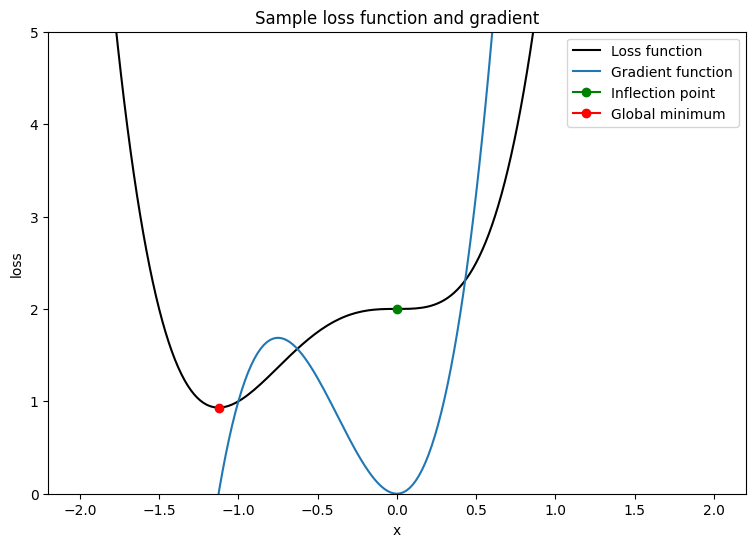

In [5]:
x_vals = tf.linspace(-2, 2, 201)
x_vals = tf.cast(x_vals, tf.float32)

def loss(x):
  return 2*(x**4) + 3*(x**3) + 2

def grad(f, x):
  with tf.GradientTape() as tape:
    tape.watch(x)
    result = f(x)
  return tape.gradient(result, x)

plt.plot(x_vals, loss(x_vals), c='k', label = "Loss function")
plt.plot(x_vals, grad(loss, x_vals), c='tab:blue', label = "Gradient function")
plt.plot(0, loss(0),  marker="o", c='g', label = "Inflection point")
plt.plot(-9/8, loss(-9/8),  marker="o", c='r', label = "Global minimum")
plt.legend()
plt.ylim(0,5)
plt.xlabel("x")
plt.ylabel("loss")
plt.title("Sample loss function and gradient");

编写一个函数来测试具有单个变量损失函数的优化器的收敛性。假设当更新参数在时间步骤 $t$ 的值与其原先在时间步骤 $t-1$ 的值相同时，即已实现收敛。在一定数量的迭代后终止测试，并在过程中跟踪任何梯度爆炸情况。为了对优化算法提出真正的挑战，以不良方式初始化参数。在上面的示例中，$x = 2$ 是一个不错的选择，因为它涉及到较陡梯度并且还会导致出现拐点。

In [6]:
def convergence_test(optimizer, loss_fn, grad_fn=grad, init_val=2., max_iters=2000):
  # Function for optimizer convergence test
  print(optimizer.title)
  print("-------------------------------")
  # Initializing variables and structures
  x_star = tf.Variable(init_val)
  param_path = []
  converged = False

  for iter in range(1, max_iters + 1):
    x_grad = grad_fn(loss_fn, x_star)

    # Case for exploding gradient
    if tf.math.is_nan(x_grad):
      print(f"Gradient exploded at iteration {iter}\n")
      return []

    # Updating the variable and storing its old-version
    x_old = x_star.numpy()
    optimizer.apply_gradients([x_grad], [x_star])
    param_path.append(x_star.numpy())

    # Checking for convergence
    if x_star == x_old:
      print(f"Converged in {iter} iterations\n")
      converged = True
      break
      
  # Print early termination message
  if not converged:
    print(f"Exceeded maximum of {max_iters} iterations. Test terminated.\n")
  return param_path

针对以下学习率测试梯度下降优化器的收敛性：1e-3、1e-2、1e-1

In [7]:
param_map_gd = {}
learning_rates = [1e-3, 1e-2, 1e-1]
for learning_rate in learning_rates:
  param_map_gd[learning_rate] = (convergence_test(
      GradientDescent(learning_rate=learning_rate), loss_fn=loss))

Gradient descent optimizer: learning rate=0.001
-------------------------------


Exceeded maximum of 2000 iterations. Test terminated.

Gradient descent optimizer: learning rate=0.01
-------------------------------


Exceeded maximum of 2000 iterations. Test terminated.

Gradient descent optimizer: learning rate=0.1
-------------------------------
Gradient exploded at iteration 6



在损失函数的等高线图上呈现参数的路径。

In [8]:
def viz_paths(param_map, x_vals, loss_fn, title, max_iters=2000):
  # Creating a controur plot of the loss function
  t_vals = tf.range(1., max_iters + 100.)
  t_grid, x_grid = tf.meshgrid(t_vals, x_vals)
  loss_grid = tf.math.log(loss_fn(x_grid))
  plt.pcolormesh(t_vals, x_vals, loss_grid, vmin=0, shading='nearest')
  colors = ['r', 'w', 'c']
  # Plotting the parameter paths over the contour plot
  for i, learning_rate in enumerate(param_map):
    param_path = param_map[learning_rate]
    if len(param_path) > 0:
      x_star = param_path[-1]
      plt.plot(t_vals[:len(param_path)], param_path, c=colors[i])
      plt.plot(len(param_path), x_star, marker='o', c=colors[i], 
              label = f"x*: learning rate={learning_rate}")
  plt.xlabel("Iterations")
  plt.ylabel("Parameter value")
  plt.legend()
  plt.title(f"{title} parameter paths")

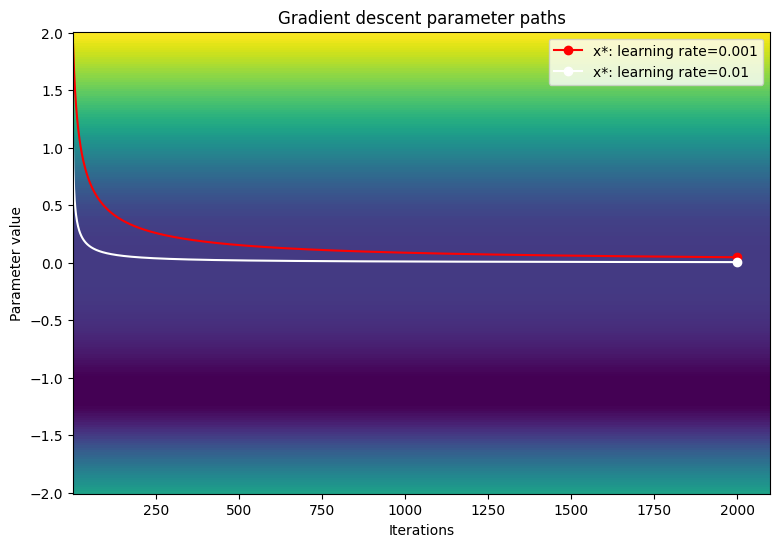

In [9]:
viz_paths(param_map_gd, x_vals, loss, "Gradient descent")

当使用较小的学习率时，梯度下降似乎停滞在拐点处。提高学习率即加大步长，因此可以在停滞区域周围加快移动；然而，当损失函数十分陡峭时，这会带来在早期迭代中发生梯度爆炸的风险。

## 具有动量的梯度下降

具有动量的梯度下降不仅使用梯度来更新变量，而且还涉及到基于变量先前更新的变量位置变化。动量参数决定了时间步骤 $t-1$ 的更新对于时间步骤 $t$ 的更新所含影响的程度。累积动量有助于使变量能够相比基本梯度下降更快地通过停滞区域。动量更新规则如下：

$$\Delta_x^{[t]} = lr \cdot L^\prime(x^{[t-1]}) + p \cdot \Delta_x^{[t-1]}$$

$$x^{[t]} = x^{[t-1]} - \Delta_x^{[t]}$$

其中

- $x$：经优化的变量
- $\Delta_x$：$x$ 的变化
- $lr$：学习率
- $L^\prime(x)$：损失函数相对于 x 的梯度
- $p$：动量参数

In [10]:
class Momentum(tf.Module):

  def __init__(self, learning_rate=1e-3, momentum=0.7):
    # Initialize parameters
    self.learning_rate = learning_rate
    self.momentum = momentum
    self.change = 0.
    self.title = f"Gradient descent optimizer: learning rate={self.learning_rate}"

  def apply_gradients(self, grads, vars):
    # Update variables 
    for grad, var in zip(grads, vars):
      curr_change = self.learning_rate*grad + self.momentum*self.change
      var.assign_sub(curr_change)
      self.change = curr_change

针对以下学习率测试动量优化器的收敛性：1e-3、1e-2、1e-1

In [11]:
param_map_mtm = {}
learning_rates = [1e-3, 1e-2, 1e-1]
for learning_rate in learning_rates:
  param_map_mtm[learning_rate] = (convergence_test(
      Momentum(learning_rate=learning_rate),
      loss_fn=loss, grad_fn=grad))

Gradient descent optimizer: learning rate=0.001
-------------------------------


Exceeded maximum of 2000 iterations. Test terminated.

Gradient descent optimizer: learning rate=0.01
-------------------------------


Converged in 80 iterations

Gradient descent optimizer: learning rate=0.1
-------------------------------
Gradient exploded at iteration 6



在损失函数的等高线图上呈现参数的路径。

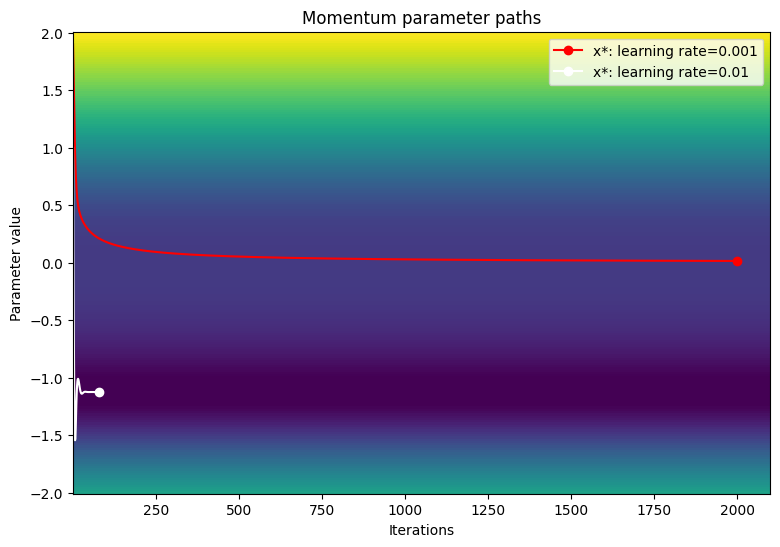

In [12]:
viz_paths(param_map_mtm, x_vals, loss, "Momentum")

## 自适应矩估计 (Adam)

自适应矩估计 (Adam) 算法是一种高效且高度泛化的优化技术，它利用了两种关键的梯度下降算法：动量和均方根传播 (RMSP)。动量会通过使用一阶矩（梯度之和）和衰减参数来帮助加速梯度下降。RMSP 与之类似，差别是会利用二阶矩（梯度平方和）。

Adam 算法将一阶矩与二阶矩相结合，因此可提供泛化能力更高的更新规则。变量 $x$ 的符号可通过计算 $\frac{x}{\sqrt{x^2}}$ 来确定。Adam 优化器基于这一事实来计算实际上是平滑符号的更新步骤。优化器并不计算 $\frac{x}{\sqrt{x^2}}$，而是针对每个变量更新计算 $x$（一阶矩）和 $x^2$（二阶矩）的平滑版本。


**Adam 算法**

$\beta_1 \gets 0.9 ; \triangleright \text{literature value}$

$\beta_2 \gets 0.999 ; \triangleright \text{literature value}$

$lr \gets \text{1e-3} ; \triangleright \text{configurable learning rate}$

$\epsilon \gets \text{1e-7} ; \triangleright \text{prevents divide by 0 error}$

$V_{dv} \gets \vec {\underset{n\times1}{0}} ;\triangleright \text{stores momentum updates for each variable}$

$S_{dv} \gets \vec {\underset{n\times1}{0}} ; \triangleright \text{stores RMSP updates for each variable}$

$t \gets 1$

$\text{On iteration } t:$

$;;;; \text{For} (\frac{dL}{dv}, v) \text{ in gradient variable pairs}:$

$;;;;;;;; V_{dv_i} = \beta_1V_{dv_i} + (1 - \beta_1)\frac{dL}{dv} ; \triangleright \text{momentum update}$

$;;;;;;;; S_{dv_i} = \beta_2V_{dv_i} + (1 - \beta_2)(\frac{dL}{dv})^2 ; \triangleright \text{RMSP update}$

$;;;;;;;; v_{dv}^{bc} = \frac{V_{dv_i}}{(1-\beta_1)^t} ; \triangleright \text{momentum bias correction}$

$;;;;;;;; s_{dv}^{bc} = \frac{S_{dv_i}}{(1-\beta_2)^t} ; \triangleright \text{RMSP bias correction}$

$;;;;;;;; v = v - lr\frac{v_{dv}^{bc}}{\sqrt{s_{dv}^{bc}} + \epsilon} ; \triangleright \text{parameter update}$

$;;;;;;;; t = t + 1$

**算法结束**

假设 $V_{dv}$ 和 $S_{dv}$ 初始化为 0，且 $\beta_1$ 和 $\beta_2$ 接近于 1，则动量和 RMSP 更新会自然偏向 0；因此，变量可以受益于偏差校正。偏差校正还有助于控制权重在接近全局最小值时的振荡。

In [13]:
class Adam(tf.Module):
  
    def __init__(self, learning_rate=1e-3, beta_1=0.9, beta_2=0.999, ep=1e-7):
      # Initialize the Adam parameters
      self.beta_1 = beta_1
      self.beta_2 = beta_2
      self.learning_rate = learning_rate
      self.ep = ep
      self.t = 1.
      self.v_dvar, self.s_dvar = [], []
      self.title = f"Adam: learning rate={self.learning_rate}"
      self.built = False

    def apply_gradients(self, grads, vars):
      # Set up moment and RMSprop slots for each variable on the first call
      if not self.built:
        for var in vars:
          v = tf.Variable(tf.zeros(shape=var.shape))
          s = tf.Variable(tf.zeros(shape=var.shape))
          self.v_dvar.append(v)
          self.s_dvar.append(s)
        self.built = True
      # Perform Adam updates
      for i, (d_var, var) in enumerate(zip(grads, vars)):
        # Moment calculation
        self.v_dvar[i] = self.beta_1*self.v_dvar[i] + (1-self.beta_1)*d_var
        # RMSprop calculation
        self.s_dvar[i] = self.beta_2*self.s_dvar[i] + (1-self.beta_2)*tf.square(d_var)
        # Bias correction
        v_dvar_bc = self.v_dvar[i]/(1-(self.beta_1**self.t))
        s_dvar_bc = self.s_dvar[i]/(1-(self.beta_2**self.t))
        # Update model variables
        var.assign_sub(self.learning_rate*(v_dvar_bc/(tf.sqrt(s_dvar_bc) + self.ep)))
      # Increment the iteration counter
      self.t += 1.

使用与梯度下降示例相同的学习率测试 Adam 优化器的性能。 

In [14]:
param_map_adam = {}
learning_rates = [1e-3, 1e-2, 1e-1]
for learning_rate in learning_rates:
  param_map_adam[learning_rate] = (convergence_test(
      Adam(learning_rate=learning_rate), loss_fn=loss))

Adam: learning rate=0.001
-------------------------------


Exceeded maximum of 2000 iterations. Test terminated.

Adam: learning rate=0.01
-------------------------------


Exceeded maximum of 2000 iterations. Test terminated.

Adam: learning rate=0.1
-------------------------------


Converged in 1156 iterations



在损失函数的等高线图上呈现参数的路径。

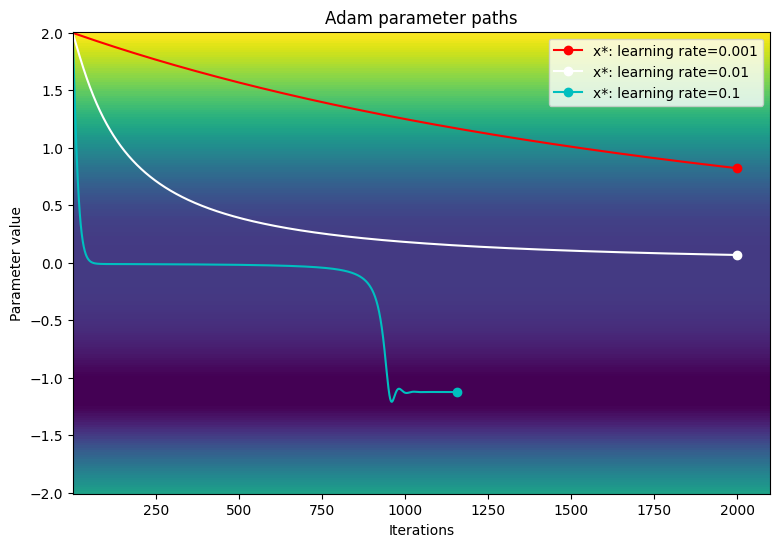

In [15]:
viz_paths(param_map_adam, x_vals, loss, "Adam")

在此特定示例中，当使用较小的学习率时，Adam 优化器与传统梯度下降相比收敛速度较慢。但当学习率较大时，该算法成功地越过了停滞区域并收敛到全局最小值。由于 Adam 在遇到较大梯度时可动态缩放学习率，不再存在梯度爆炸问题。

## 结论

此笔记本介绍了使用 [TensorFlow Core API](https://tensorflow.google.cn/guide/core) 编写和比较优化器的基础知识。尽管像 Adam 这样的预构建优化器具备可泛化性，但它们可能并非总是每个模型或数据集的最佳选择。对优化过程进行精细控制有助于简化机器学习训练工作流并提高整体性能。有关自定义优化器的更多示例，请参阅以下文档：

- [多层感知器](https://tensorflow.google.cn/guide/core/mlp_core)教程和[分布式训练]()中使用了此 Adam 优化器
- [Model Garden](https://blog.tensorflow.org/2020/03/introducing-model-garden-for-tensorflow-2.html) 中包含多种使用 Core API 编写的[自定义优化器](https://github.com/tensorflow/models/tree/master/official/modeling/optimization)。
